# Inicio
Iremos usar um modelo de rede neural para manipular séries temporais.\
Iremos usar o NeuralProphet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import torch
import os
import pickle

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error
)

from datetime import datetime
from neuralprophet.configure import Season
torch.serialization.add_safe_globals([Season])

import neuralprophet

/home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/lightning_fabric/__init__.py:29: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/operador/Documentos/Estudos/Projetos/ScienceMarket/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
codigo = 'BRL=X'
inicio = '2000-01-01'
fim = pd.to_datetime(datetime.now()).strftime('%Y-%m-%d')

data = yf.download(codigo, start=inicio, end=fim, multi_level_index=False)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_22004/117030692.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(codigo, start=inicio, end=fim, multi_level_index=False)

[*********************100%***********************]  1 of 1 completed


In [3]:
# Transformando em dataframe
df = pd.DataFrame(data)

# Transformando dados
df = df[['Close']].reset_index()
df.columns = ['ds', 'y']

In [4]:
df_formatted = pd.DataFrame({
    'ds': pd.to_datetime(df['ds']),
    'y': df['y'].astype(float)
})
df_formatted = df_formatted.dropna()
df_formatted = df_formatted.sort_values('ds').reset_index(drop=True)

## Modelo
Iremos treinar o modelo com os dados

### Modelo CBoW

In [2]:
# ---- Dados ----
sentiment_1 = pd.read_csv('../../data/financial_sentiment_1/data.csv')
sentiment_2 = pd.read_csv('../../data/financial_sentiment_2/data.csv', encoding='latin1')
sentiment_3 = pd.read_csv('../../data/financial_sentiment_3/data.csv')

# --- Tratamento 1 ---
sentiment_1['Sentiment'] = sentiment_1['Sentiment'].map({'positive': 1, 'negative': 0, 'neutral': 2})

# --- Tratamento 2 ---
sentiment_2.columns = ['Sentiment', 'Sentence']
sentiment_2 = sentiment_2[['Sentence', 'Sentiment']]
sentiment_2['Sentiment'] = sentiment_2['Sentiment'].map({'positive': 1, 'negative': 0, 'neutral': 2})

# --- Tratamento 3 ---
# Os dados 3 estão mais completos, talvez essas informações podem ser usadas.
sentiment_3 = pd.DataFrame({
    'Sentence' :sentiment_3['Title'],
    'Sentiment' :sentiment_3['Sentiment'],
})
sentiment_3['Sentiment'] = sentiment_3['Sentiment'].map({'positive': 1, 'negative': 0, 'neutral': 2})

# ---- Dataset Final ----
df_sentiment = pd.concat([sentiment_1, sentiment_2, sentiment_3], ignore_index=True)
df_sentiment = df_sentiment.drop((df_sentiment.loc[df_sentiment['Sentiment'] == 2]).index)
df_sentiment = df_sentiment.dropna(subset=['Sentence', 'Sentiment'])

In [3]:
# ---- Implementação do CBoW
# Ainda é necessário arrumar o caminho para que seja possível importar a classe

import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../GLN")))
from continuous_bag_of_words import CBoW

In [4]:
classifier_continuous = CBoW.Classifier()
classifier_continuous.build(df_sentiment)

Model trained successfully!
Accuracy: 73.55%


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [ ]:
# ---- Fazendo uma previsão com classifier ----
texto_pred = [
    "New crypto coin going strong in this weekend!", 
    "Dolar on low", 
    "The price of oil is going down.",
    "$ESI on lows, down $1.50 to $2.50 BK a real possibility"
    ]

# Verifica se o modelo está treinado
classifier_continuous.predict(texto_pred)

# Ainda é necessário arrumar o modelo de previsão e verificar se está errando.

array([1, 1, 1, 1])

### Modelo NN

In [5]:
modelo = neuralprophet.NeuralProphet(
    growth='linear',
    changepoints_range=0.9,
    n_changepoints=25,

    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,

    batch_size=32,
    learning_rate=0.01,

    seasonality_mode='multiplicative',
    normalize='minmax',

    trend_reg=0.01,
    ar_reg=0.01,

    n_forecasts=1,

    trend_reg_threshold=False
)
metrics = modelo.fit(
    df_formatted,
    freq='D',
    validation_df=None,
    progress='bar'
    )

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket_Original/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:464: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  if df.groupby("ID").apply(lambda x: x.duplicated("ds").any()).any():

WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket_Original/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecat

Epoch 70: 100%|██████████| 70/70 [00:00<00:00, 79.87it/s, loss=0.0046, v_num=1, MAE=0.215, RMSE=0.268, Loss=0.00463, RegLoss=0.000327]    


### Testando modelo

In [6]:
dados_futuros = modelo.make_future_dataframe(df_formatted, periods=365)
previsao_futura = modelo.predict(dados_futuros)

previsoes_historicas = modelo.predict(df_formatted)

WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket_Original/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.542% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket_Original/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket_Original/.venv/lib/python3.12/site-packages/neural

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket_Original/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.726% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket_Original/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /home/operador/Documento

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.23it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket_Original/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.542% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket_Original/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)



WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket_Original/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket_Original/.venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 99.542% of the data.
WARNING - (py.warnings._showwarnmsg) - /home/operador/Do

Predicting DataLoader 0: 100%|██████████| 6/6 [00:00<00:00, 130.36it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [7]:
previsao_futura.head()

,ds,y,yhat1,trend,season_yearly
0,2025-09-13,None,6.055782,6.039128,0.016653
1,2025-09-14,None,6.063865,6.040434,0.023431
2,2025-09-15,None,6.071926,6.041738,0.030188
3,2025-09-16,None,6.079906,6.043042,0.036863
4,2025-09-17,None,6.087801,6.044345,0.043455


In [8]:
modelo.plot_components(previsao_futura)

ERROR - (NP.plotly.plot_components) - plotly-resampler is not installed. Please install it to use the resampler.
WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket_Original/.venv/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:283: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fcst = fcst.fillna(value=np.nan)

WARNING - (py.warnings._showwarnmsg) - /home/operador/Documentos/Estudos/Projetos/ScienceMarket_Original/.venv/lib/python3.12/site-packages/neuralprophet/plot_forecast_plotly.py:410: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.

### Visualizando previsão

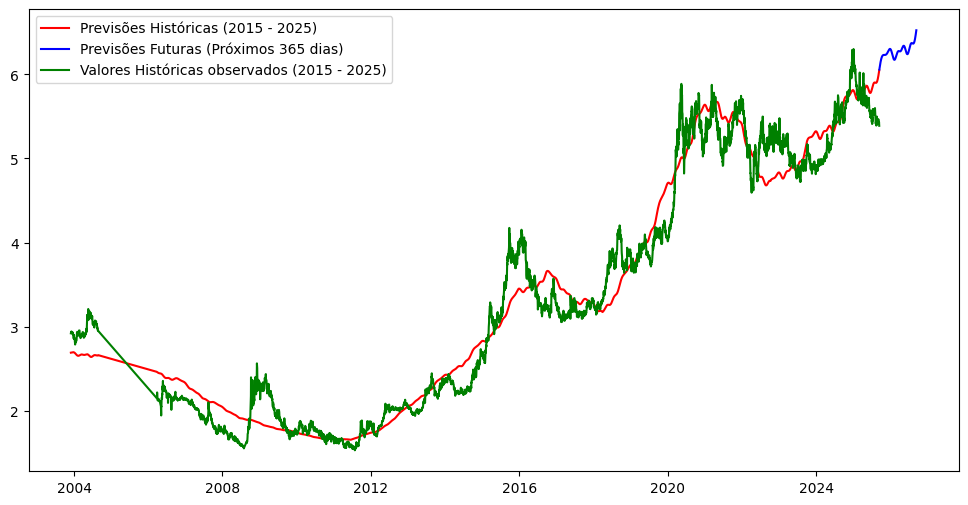

In [9]:
plt.figure(figsize=(12, 6))

# Previsão histórica
plt.plot(
    previsoes_historicas['ds'],
    previsoes_historicas['yhat1'],
    label='Previsões Históricas (2015 - 2025)',
    c='r',
)

# Previsão futura
plt.plot(
    previsao_futura['ds'],
    previsao_futura['yhat1'],
    label='Previsões Futuras (Próximos 365 dias)',
    c='b',
)

# Dados históricos
plt.plot(
    df_formatted['ds'],
    df_formatted['y'],
    label='Valores Históricas observados (2015 - 2025)',
    c='g',
)

plt.legend()
plt.show()

### Avaliando modelo

In [10]:
# R2 mede quanto da variância dos dados é explicada pelo seu modelo
r2_score(y_true=previsoes_historicas['y'], y_pred=previsoes_historicas['yhat1'])

# Quanto mais próximo de 1 é melhor

0.9631603144314222

In [11]:
# MSE (Erro médio absoluto)
mean_absolute_error(y_true=previsoes_historicas['y'], y_pred=previsoes_historicas['yhat1'])

# Erro médio que o modelo tem
# Quanto menor melhor

0.21580204624387345

In [12]:
# Porcentagem média de erro
mean_absolute_percentage_error(y_true=previsoes_historicas['y'], y_pred=previsoes_historicas['yhat1']) * 100

# Quanto menor melhor

6.983317539162563

### Salvando modelo

In [ ]:
os.makedirs('../Models/Neural', exist_ok=True)

In [ ]:
with open('../Models/Neural/neural_model_v2.pkl', 'wb') as f:
    pickle.dump(modelo, f)

print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


### Carregando modelo

In [ ]:
def load_neural_model():
    with open('../Models/Neural/neural_model_v1.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
    
    return loaded_model

loaded_model = load_neural_model()